In [26]:
import seaborn as sns 
import matplotlib.pyplot as plt 

import pandas as pd 
import numpy as np 
import statsmodels.api as sm

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics

from sklearn import datasets
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score)

#Scaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance

import os


from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC


In [2]:
def apr(y_real, y_pred):
    accuracy = accuracy_score(y_real, y_pred)
    precision = precision_score(y_real, y_pred)
    recall = recall_score(y_real, y_pred)
    f1 = f1_score(y_real, y_pred)
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1

In [3]:
df = pd.read_csv('oasis_longitudinal.csv')

In [121]:
data = df.copy()

In [122]:
# data["SES"].fillna(data.groupby("EDUC")["SES"].transform("median"), inplace=True)

In [123]:
# data.drop(columns = ['SES'], inplace = True)

In [124]:
data.dropna(inplace = True)

In [125]:
data.isnull().sum()

Subject ID    0
MRI ID        0
Group         0
Visit         0
MR Delay      0
M/F           0
Hand          0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

In [126]:
#Creating 2 dataframes

data1 = data.drop_duplicates(subset = "Subject ID",
                     keep = 'first')
print(data1.shape)
 
data2 = data.drop(data[data['Visit'] == 1].index)
data2.drop_duplicates(subset = "Subject ID",
                     keep = 'first',
                     inplace = True)
print(data2.shape)

(142, 15)
(142, 15)


In [127]:
data2.columns = ['Subject ID', 'MRI ID', 'Group', 'Visit 2', 'MR Delay 2', 'M/F', 'Hand', 'Age 2', 'EDUC 2', 'SES 2', 'MMSE 2', 'CDR 2',
                'eTIV 2', 'nWBV 2', 'ASF 2']

In [128]:
#merging 2 dataframes
data3 = pd.merge(data1,data2,on='Subject ID')

In [129]:
data3['MMSE minus'] = data3['MMSE 2'] - data3['MMSE']
data3['EDUC minus'] = data3['EDUC 2'] - data3['EDUC']
#data3['SES minus'] = data3['SES 2'] - data3['SES']
data3['CDR minus'] = data3['CDR 2'] - data3['CDR']
data3['eTIV minus'] = data3['eTIV 2'] - data3['eTIV']
data3['ASF minus'] = data3['ASF 2'] - data3['ASF']
data3['Age minus'] = data3['Age 2'] - data3['Age']
data3['nWBV minus'] = data3['nWBV 2'] - data3['nWBV']
data3['MR Delay minus'] = data3['MR Delay 2'] - data3['MR Delay']
data3['Visit minus'] = data3['Visit 2'] - data3['Visit']

In [130]:
feature_columns =  [  'Group_x',  'M/F_x',
       'MMSE 2', 'EDUC',  'CDR 2',  'Age 2',
       'eTIV minus', 'ASF minus', 'nWBV minus', 'MR Delay minus'
       ]


data4 = data3[feature_columns]

In [131]:
data5 = data4.copy()

In [132]:

data5['Group_x'].replace({"Converted":"Demented"}, inplace= True) #converting Converted to Demented


#One hoc encoding!
data5['Group_x'] = data5['Group_x'].replace(['Nondemented','Demented'], [0,1]) #1 hoc encoding ND and D
data5 = pd.get_dummies(data5, prefix = 'Gender', columns=['M/F_x'], drop_first=True) # 1 hoc encdoing M/F

In [133]:
feature_cols2 =  ['MMSE 2', 
                  'EDUC', 
                  #'SES', 
                  #'CDR 2',
                  'Age 2',
                  'eTIV minus',
                  'nWBV minus', 
                  #'MR Delay minus',
                  'Gender_M']

In [134]:
X = data5[feature_cols2]
X = sm.add_constant(X)
y = data5['Group_x']

In [135]:
#Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 15, stratify=y)


In [136]:
X_train_eng = X_train.copy()
X_test_eng = X_test.copy()

In [137]:
scaler = MinMaxScaler()

In [138]:
# this code serves to separate the constant from the dataframe
# if the consant is scaled it is reduced to 0 and becomes useless
# here we also re-index the scaled dataframe since it loses the index when scaled
if 'const' in list(X_train_eng.columns) and 'const' in list(X_test_eng.columns):

    # Fit and scale the training data
    c = pd.DataFrame(X_train_eng['const'])
    c.reset_index(drop = True, inplace = True)

    X_train_eng.drop(columns = 'const', inplace = True)

    scaled_X_train = scaler.fit_transform(X_train_eng)

    precols = list(X_train_eng.columns)
    scaled_X_train = pd.DataFrame(scaled_X_train, columns= precols)

    scaled_X_train = pd.concat([c,scaled_X_train], axis = 1)

    scaled_X_train.set_index(X_train_eng.reset_index()['index'], inplace = True)

    # Scale the test data 

    k = pd.DataFrame(X_test_eng['const'])
    k.reset_index(drop = True, inplace = True)

    X_test_eng.drop(columns = 'const', inplace = True)

    scaled_X_test = scaler.transform(X_test_eng)

    scaled_X_test = pd.DataFrame(scaled_X_test, columns= precols)

    scaled_X_test = pd.concat([k,scaled_X_test], axis = 1)

    scaled_X_test.set_index(X_test_eng.reset_index()['index'], inplace = True)

else:
    precols = list(X_train_eng.columns)
    
    scaled_X_train = scaler.fit_transform(X_train_eng)
    scaled_X_train = pd.DataFrame(scaled_X_train, columns= precols)
    
    scaled_X_train.set_index(X_train_eng.reset_index()['index'], inplace = True)

    scaled_X_test = scaler.transform(X_test_eng)
    scaled_X_test = pd.DataFrame(scaled_X_test, columns= precols)
    
    scaled_X_test.set_index(X_test_eng.reset_index()['index'], inplace = True)

In [139]:
from sklearn.svm import SVC
clf_svm = SVC(random_state=42)
clf_svm.fit(scaled_X_train, y_train) #training it on the training data

SVC(random_state=42)

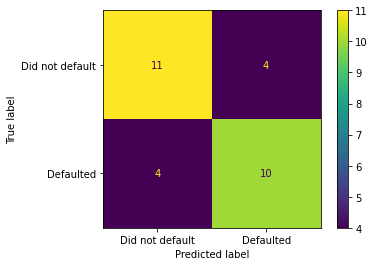

In [140]:
plot_confusion_matrix(clf_svm, #train vector machine
                      scaled_X_test, #passing our test
                      y_test, #passing our y test
                      values_format = 'd',
                      display_labels=["Did not default", "Defaulted"]
                     )

Use Cross Validation! Using GridSearchCV()

In [141]:
# creating list of parameter values
param_grid = [
    {'kernel': ['linear'], 
     'C': [0.01, 0.1, 1, 10, 20, 30, 40, 50, 100, 1000],
     'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001]}
]


optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy'
)

optimal_params.fit(scaled_X_train,y_train)
print(optimal_params.best_params_)

{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


Building, Evaluating, Drawing and Interpreting the FINAL SVM

In [142]:
clf_svm = SVC(random_state=42, C=10, gamma='scale', kernel = 'linear')
clf_svm.fit(scaled_X_train, y_train) 

SVC(C=10, kernel='linear', random_state=42)

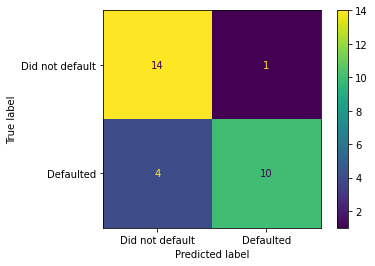

In [143]:
plot_confusion_matrix(clf_svm, #train vector machine
                      scaled_X_test, #passing our test
                      y_test, #passing our y test
                      values_format = 'd',
                      display_labels=["Did not default", "Defaulted"]
                     )

In [144]:
# print(classification_report(y_train, clf_svm.predict(scaled_X_train)))

In [145]:
print(classification_report(y_test, clf_svm.predict(scaled_X_test)))

#0.93, 0.69
#0.81, 

              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.91      0.71      0.80        14

    accuracy                           0.83        29
   macro avg       0.84      0.82      0.82        29
weighted avg       0.84      0.83      0.83        29



In [146]:
apr(y_test, clf_svm.predict(scaled_X_test))
#0.8, 0.91, 0.68, 0.78

Accuracy:0.8275862068965517
Precision:0.9090909090909091
Recall:0.7142857142857143
F1:0.8


(0.8275862068965517, 0.9090909090909091, 0.7142857142857143, 0.8)

In [147]:
# #train scores
apr(y_train, clf_svm.predict(scaled_X_train))


Accuracy:0.8141592920353983
Precision:0.8888888888888888
Recall:0.7142857142857143
F1:0.792079207920792


(0.8141592920353983, 0.8888888888888888, 0.7142857142857143, 0.792079207920792)